In [17]:
import re
import os
import sys
import scipy.io
import numpy as np
from tqdm import tqdm
# from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

genvox_path = "/home/saiakarsh/Desktop/GenVox/"
if not genvox_path in sys.path:
    sys.path.append(genvox_path)

from configs import TextConfig
from utils.formatters import BaseDataset
from core.processors import TextProcessor

In [18]:
def tokenize_into_words(sentence):
    clean_sentence = re.sub(r"[^a-z0-9 \_\-]", '', sentence)
    return clean_sentence.split()

dataset = BaseDataset(
    dataset_path="../data/LJSpeech_test",
    formatter="ljspeech",
    dataset_name="ljspeech"
)

total_data = dataset.data

text_config = TextConfig(
    language="english",
    cleaners=["base_cleaners"],
    use_g2p=False
)

text_processor = TextProcessor(config=text_config)

print(f"data count: {len(total_data)}")
print(f"sample_data: {total_data[0]}")

data count: 1000
sample_data: {'text': 'this Wallace added that his friend had made several voyages with the distinct intention of superintending the predetermined shipwrecks.', 'audio_path': '../data/LJSpeech_test/wavs/LJ013-0039.wav', 'unique_id': 'ljspeech#LJ013-0039'}


In [23]:
fs_set = set()
wav_len_list = []
all_tokens = Counter()
all_words = Counter()

for data in tqdm(total_data):
    utt_id, text, wav_path = data["unique_id"], data["text"], data["audio_path"]
    tokens = text_processor.tokenize(text)
    clean_text = ''.join(tokens)
    all_tokens.update(tokens)
    all_words.update(tokenize_into_words(clean_text))
    fs, wav = scipy.io.wavfile.read(wav_path)
    fs_set.add(fs)
    wav_len_list.append(wav.shape[0] / fs)

print(fs_set)
print(f"unique chars: {len(all_tokens.keys())}")
print(all_tokens.most_common(15))
print(f"unique words: {len(all_words.keys())}")
print(all_words.most_common(15))

100%|██████████| 1000/1000 [00:00<00:00, 1787.10it/s]

{22050}
unique chars: 35
[(' ', 15995), ('e', 10480), ('t', 7788), ('a', 6218), ('o', 6072), ('i', 5870), ('n', 5762), ('s', 5404), ('r', 4827), ('h', 4438), ('d', 3488), ('l', 3021), ('c', 2341), ('f', 2056), ('u', 2026)]
unique words: 3928
[('the', 1369), ('of', 684), ('and', 474), ('to', 455), ('in', 381), ('a', 342), ('was', 305), ('that', 229), ('he', 224), ('his', 183), ('on', 141), ('it', 127), ('by', 125), ('as', 121), ('had', 117)]


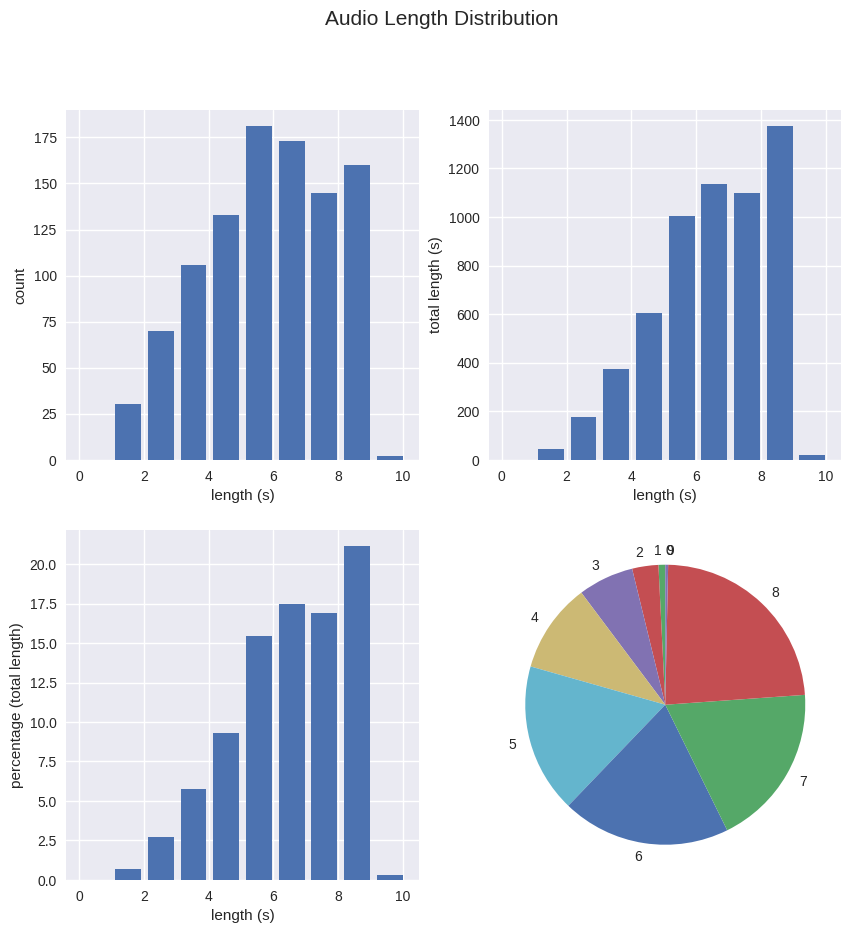

In [22]:
wav_lens = np.array(wav_len_list)
max_len = np.max(wav_lens)
nbins = 10
bin_intervals = np.linspace(0, max_len, nbins + 1)
bin_label = ((bin_intervals[: -1] + bin_intervals[1: ]) / 2)
bins = np.zeros(nbins, dtype=int)

for wav_len in wav_lens:
    bin_ind = int((wav_len / max_len) * (nbins - 1))
    bins[bin_ind] += 1

plt.figure(figsize=[10, 10])
plt.suptitle("Audio Length Distribution", fontsize=15)
plt.subplot(221)
plt.bar(bin_label, bins)
plt.ylabel("count")
plt.xlabel("length (s)")

plt.subplot(222)
bins_tlen = bins * bin_label
plt.bar(bin_label, bins_tlen)
plt.ylabel("total length (s)")
plt.xlabel("length (s)")

plt.subplot(223)
bins_percentage = (bins_tlen / np.sum(wav_lens)) * 100
plt.bar(bin_label, bins_percentage)
plt.ylabel("percentage (total length)")
plt.xlabel("length (s)")

plt.subplot(224)
plt.pie(bins_percentage, labels = (bin_label).astype(int), startangle = 90)
plt.show()